In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
fastfood = pd.read_csv("fastfood.csv")
fastfood

,restaurant,item,calories,cal_fat,total_fat,sat_fat,trans_fat,cholesterol,sodium,total_carb,fiber,sugar,protein,vit_a,vit_c,calcium,salad
0,Mcdonalds,Artisan Grilled Chicken Sandwich,380,60,7,2.0,0.0,95,1110,44,3.0,11,37.0,4.0,20.0,20.0,Other
1,Mcdonalds,Single Bacon Smokehouse Burger,840,410,45,17.0,1.5,130,1580,62,2.0,18,46.0,6.0,20.0,20.0,Other
2,Mcdonalds,Double Bacon Smokehouse Burger,1130,600,67,27.0,3.0,220,1920,63,3.0,18,70.0,10.0,20.0,50.0,Other
3,Mcdonalds,Grilled Bacon Smokehouse Chicken Sandwich,750,280,31,10.0,0.5,155,1940,62,2.0,18,55.0,6.0,25.0,20.0,Other
4,Mcdonalds,Crispy Bacon Smokehouse Chicken Sandwich,920,410,45,12.0,0.5,120,1980,81,4.0,18,46.0,6.0,20.0,20.0,Other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
510,Taco Bell,Spicy Triple Double Crunchwrap,780,340,38,10.0,0.5,50,1850,87,9.0,8,23.0,20.0,10.0,25.0,Other
511,Taco Bell,Express Taco Salad w/ Chips,580,260,29,9.0,1.0,60,1270,59,8.0,7,23.0,NaN,NaN,NaN,Other
512,Taco Bell,Fiesta Taco Salad-Beef,780,380,42,10.0,1.0,60,1340,74,11.0,7,26.0,NaN,NaN,NaN,Other
513,Taco Bell,Fiesta Taco Salad-Chicken,720,320,35,7.0,0.0,70,1260,70,8.0,8,32.0,NaN,NaN,NaN,Other


In [3]:
fastfood.isna().sum()

restaurant       0
item             0
calories         0
cal_fat          0
total_fat        0
sat_fat          0
trans_fat        0
cholesterol      0
sodium           0
total_carb       0
fiber           12
sugar            0
protein          1
vit_a          214
vit_c          210
calcium        210
salad            0
dtype: int64

In [4]:
avg_calories = fastfood['calories'].mean()
avg_calories

530.9126213592233

In [5]:


# Quick overview
print("Dataset shape:", fastfood.shape)
print("\nData types and non-null counts:")
print(fastfood.info())
print("\nBasic statistics:")
print(fastfood.describe(include='all').T)
print("\nMissing values per column:")
print(fastfood.isna().sum())
print(f"\nPreviously computed avg_calories: {avg_calories:.2f}")

# Basic cleaning: strip whitespace in string columns and column names
fastfood.columns = fastfood.columns.str.strip()
str_cols = fastfood.select_dtypes(include='object').columns.tolist()
for c in str_cols:
    fastfood[c] = fastfood[c].astype(str).str.strip()

# Normalize restaurant names lightly (strip + title case)
fastfood['restaurant'] = fastfood['restaurant'].str.title().str.replace("’", "'", regex=False)

# Drop exact duplicates
df = fastfood.copy()
before = len(df)
df = df.drop_duplicates()
after = len(df)
print(f"\nDropped duplicates: {before - after}")

# Convert 'salad' to category if present
if 'salad' in df.columns:
    df['salad'] = df['salad'].astype('category')

# Imputation strategy: fill numeric NA with median per restaurant, fallback to overall median
num_cols = df.select_dtypes(include=['number']).columns.tolist()

def fill_na_with_group_median(df, cols, group_col='restaurant'):
    for col in cols:
        if df[col].isna().sum() == 0:
            continue
        group_median = df.groupby(group_col)[col].transform('median')
        filled = df[col].fillna(group_median)
        overall_median = df[col].median()
        df[col] = filled.fillna(overall_median)
    return df

df = fill_na_with_group_median(df, num_cols, group_col='restaurant')

# Verify no remaining numeric NAs
print("\nMissing values after imputation:")
print(df[num_cols].isna().sum())

# Feature engineering: calorie z-score and IQR outlier flag
df['calories_z'] = (df['calories'] - df['calories'].mean()) / df['calories'].std()
Q1 = df['calories'].quantile(0.25)
Q3 = df['calories'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df['calorie_outlier'] = ((df['calories'] < lower_bound) | (df['calories'] > upper_bound))

# Summary statistics by restaurant
rest_stats = df.groupby('restaurant')['calories'].agg(['count', 'mean', 'median', 'std']).sort_values('mean', ascending=False)
print("\nCalories by restaurant (top 10 by mean):")
print(rest_stats.head(10))

# Top high-calorie items
top_cal_items = df.sort_values('calories', ascending=False).loc[:, ['restaurant', 'item', 'calories']].head(15)
print("\nTop 15 highest calorie items:")
print(top_cal_items.to_string(index=False))

# Correlation matrix for numeric features
corr = df[num_cols].corr()
print("\nCorrelation matrix (numeric):")
print(corr)




Dataset shape: (515, 17)

Data types and non-null counts:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515 entries, 0 to 514
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   restaurant   515 non-null    object 
 1   item         515 non-null    object 
 2   calories     515 non-null    int64  
 3   cal_fat      515 non-null    int64  
 4   total_fat    515 non-null    int64  
 5   sat_fat      515 non-null    float64
 6   trans_fat    515 non-null    float64
 7   cholesterol  515 non-null    int64  
 8   sodium       515 non-null    int64  
 9   total_carb   515 non-null    int64  
 10  fiber        503 non-null    float64
 11  sugar        515 non-null    int64  
 12  protein      514 non-null    float64
 13  vit_a        301 non-null    float64
 14  vit_c        305 non-null    float64
 15  calcium      305 non-null    float64
 16  salad        515 non-null    object 
dtypes: float64(7), int64(7), object(3)

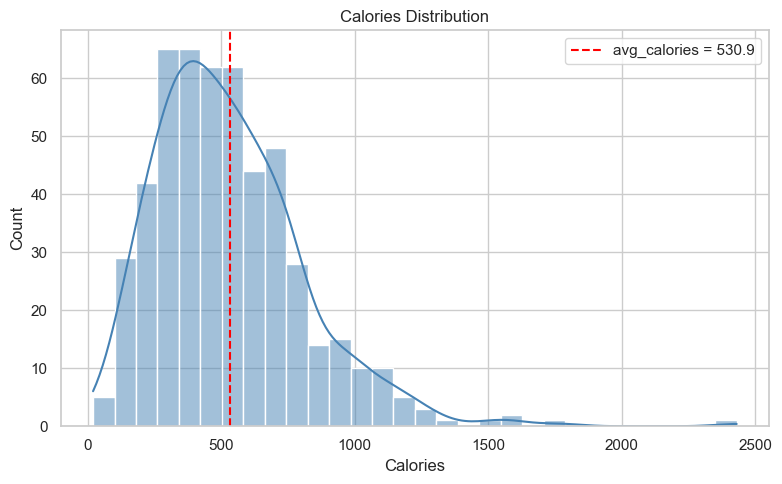

In [6]:
# Visualizations
sns.set(style="whitegrid")
# 1) Histogram + KDE for calories with mean line
plt.figure(figsize=(8, 5))
sns.histplot(df['calories'], kde=True, bins=30, color='steelblue')
plt.axvline(avg_calories, color='red', linestyle='--', label=f'avg_calories = {avg_calories:.1f}')
plt.title('Calories Distribution')
plt.xlabel('Calories')
plt.ylabel('Count')
plt.legend()
plt.tight_layout()
plt.show()


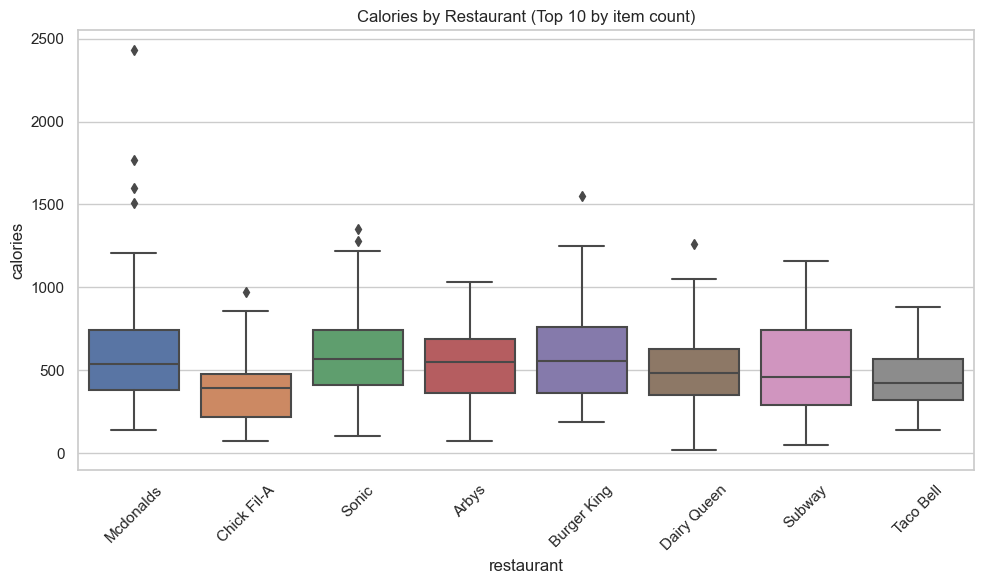

In [7]:
# 2) Boxplot of calories for top 10 restaurants by number of items
top10_by_count = df['restaurant'].value_counts().nlargest(10).index.tolist()
plt.figure(figsize=(10, 6))
sns.boxplot(data=df[df['restaurant'].isin(top10_by_count)], x='restaurant', y='calories')
plt.xticks(rotation=45)
plt.title('Calories by Restaurant (Top 10 by item count)')
plt.tight_layout()
plt.show()

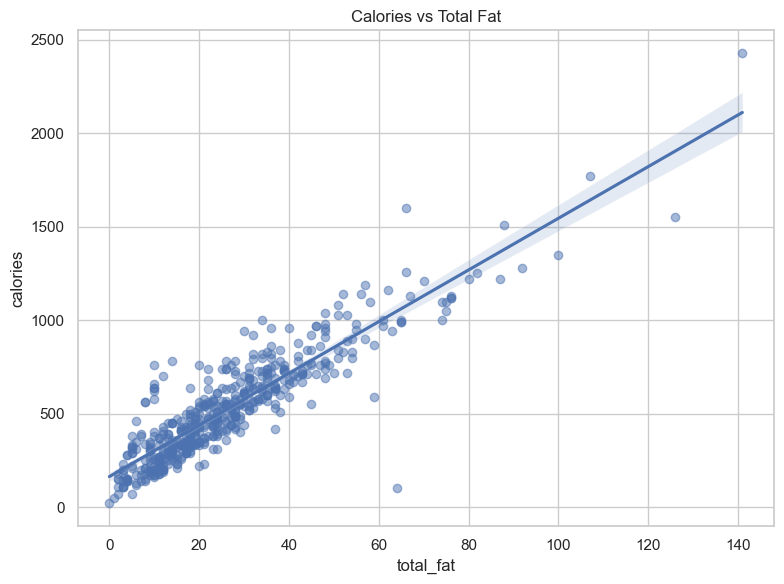

In [8]:
# 3) Scatter calories vs total_fat with regression line
plt.figure(figsize=(8, 6))
sns.regplot(data=df, x='total_fat', y='calories', scatter_kws={'alpha':0.5})
plt.title('Calories vs Total Fat')
plt.tight_layout()
plt.show()

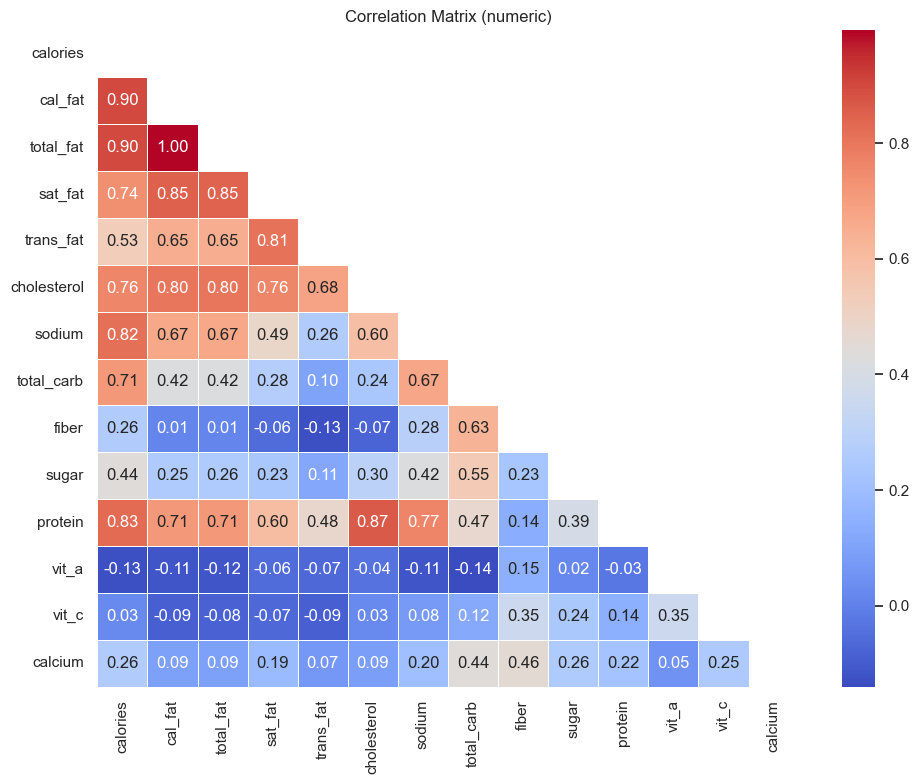

In [9]:
# 4) Heatmap of correlations
plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', linewidths=.5)
plt.title('Correlation Matrix (numeric)')
plt.tight_layout()
plt.show()

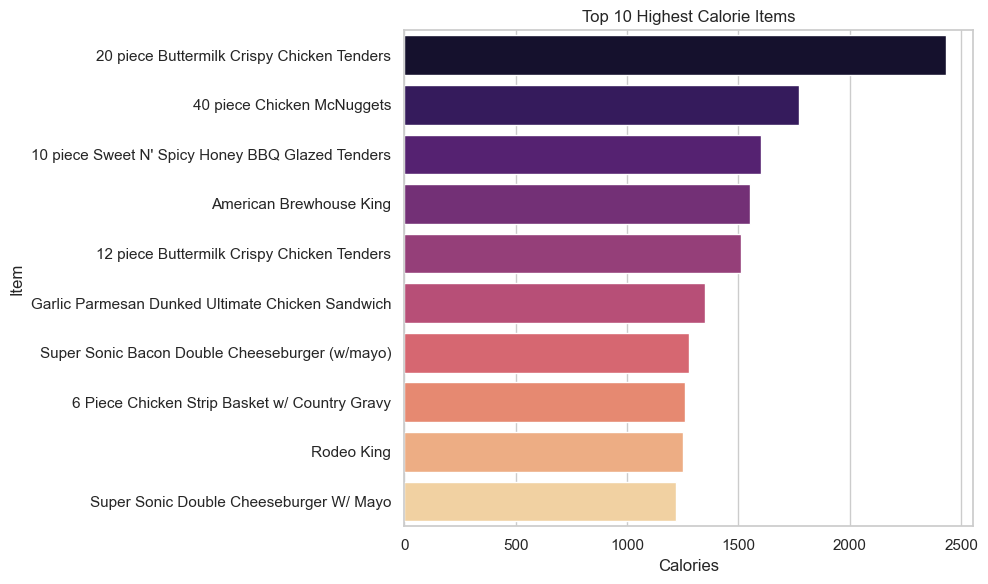

In [10]:
# 5) Barplot of top 10 highest calorie items
plt.figure(figsize=(10, 6))
sns.barplot(data=top_cal_items.head(10), x='calories', y='item', palette='magma')
plt.title('Top 10 Highest Calorie Items')
plt.xlabel('Calories')
plt.ylabel('Item')
plt.tight_layout()
plt.show()

In [11]:
# Final quick checks
print("\nFinal dataset shape:", df.shape)
print("Columns:", df.columns.tolist())


Final dataset shape: (513, 19)
Columns: ['restaurant', 'item', 'calories', 'cal_fat', 'total_fat', 'sat_fat', 'trans_fat', 'cholesterol', 'sodium', 'total_carb', 'fiber', 'sugar', 'protein', 'vit_a', 'vit_c', 'calcium', 'salad', 'calories_z', 'calorie_outlier']


In [12]:
food_data_yazio = pd.read_csv("FOOD-DATA-GROUP1.csv")
food_data_yazio

,Unnamed: 0.1,Unnamed: 0,food,Caloric Value,Fat,Saturated Fats,Monounsaturated Fats,Polyunsaturated Fats,Carbohydrates,Sugars,...,Calcium,Copper,Iron,Magnesium,Manganese,Phosphorus,Potassium,Selenium,Zinc,Nutrition Density
0,0,0,cream cheese,51,5.0,2.900,1.300,0.200,0.8,0.500,...,0.008,14.100,0.082,0.027,1.300,0.091,15.5,19.100,0.039,7.070
1,1,1,neufchatel cheese,215,19.4,10.900,4.900,0.800,3.1,2.700,...,99.500,0.034,0.100,8.500,0.088,117.300,129.2,0.054,0.700,130.100
2,2,2,requeijao cremoso light catupiry,49,3.6,2.300,0.900,0.000,0.9,3.400,...,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,5.400
3,3,3,ricotta cheese,30,2.0,1.300,0.500,0.002,1.5,0.091,...,0.097,41.200,0.097,0.096,4.000,0.024,30.8,43.800,0.035,5.196
4,4,4,cream cheese low fat,30,2.3,1.400,0.600,0.042,1.2,0.900,...,22.200,0.072,0.008,1.200,0.098,22.800,37.1,0.034,0.053,27.007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
546,546,546,chinook salmon smoked,159,5.9,1.300,2.800,1.400,0.0,0.000,...,15.000,0.300,1.200,24.500,0.055,223.000,238.0,0.027,0.400,47.038
547,547,547,cisco smoked,50,3.4,0.500,1.600,0.600,0.0,0.000,...,7.400,0.015,0.100,4.800,0.047,42.500,82.9,0.050,0.076,15.576
548,548,548,haddock smoked,33,0.3,0.049,0.006,0.055,0.0,0.000,...,13.900,0.001,0.400,15.300,0.075,71.000,117.4,0.063,0.100,21.719
549,549,549,whitefish smoked,147,1.3,0.300,0.400,0.400,0.0,0.000,...,24.500,0.400,0.700,31.300,0.091,179.500,575.3,0.030,0.700,58.398


In [13]:
food_data_yazio.isna().sum()    

Unnamed: 0.1            0
Unnamed: 0              0
food                    0
Caloric Value           0
Fat                     0
Saturated Fats          0
Monounsaturated Fats    0
Polyunsaturated Fats    0
Carbohydrates           0
Sugars                  0
Protein                 0
Dietary Fiber           0
Cholesterol             0
Sodium                  0
Water                   0
Vitamin A               0
Vitamin B1              0
Vitamin B11             0
Vitamin B12             0
Vitamin B2              0
Vitamin B3              0
Vitamin B5              0
Vitamin B6              0
Vitamin C               0
Vitamin D               0
Vitamin E               0
Vitamin K               0
Calcium                 0
Copper                  0
Iron                    0
Magnesium               0
Manganese               0
Phosphorus              0
Potassium               0
Selenium                0
Zinc                    0
Nutrition Density       0
dtype: int64

In [14]:
food_data_usda = pd.read_csv("food.csv")
food_data_usda

,Category,Description,Nutrient Data Bank Number,Data.Alpha Carotene,Data.Ash,Data.Beta Carotene,Data.Beta Cryptoxanthin,Data.Carbohydrate,Data.Cholesterol,Data.Choline,...,Data.Major Minerals.Potassium,Data.Major Minerals.Sodium,Data.Major Minerals.Zinc,Data.Vitamins.Vitamin A - IU,Data.Vitamins.Vitamin A - RAE,Data.Vitamins.Vitamin B12,Data.Vitamins.Vitamin B6,Data.Vitamins.Vitamin C,Data.Vitamins.Vitamin E,Data.Vitamins.Vitamin K
0,BUTTER,"BUTTER,WITH SALT",1001,0,2.11,158,0,0.06,215,19,...,24,576,0.09,2499,684,0.17,0.003,0.0,2.32,7.0
1,BUTTER,"BUTTER,WHIPPED,WITH SALT",1002,0,2.11,158,0,0.06,219,19,...,26,827,0.05,2499,684,0.13,0.003,0.0,2.32,7.0
2,BUTTER OIL,"BUTTER OIL,ANHYDROUS",1003,0,0.00,193,0,0.00,256,22,...,5,2,0.01,3069,840,0.01,0.001,0.0,2.80,8.6
3,CHEESE,"CHEESE,BLUE",1004,0,5.11,74,0,2.34,75,15,...,256,1395,2.66,763,198,1.22,0.166,0.0,0.25,2.4
4,CHEESE,"CHEESE,BRICK",1005,0,3.18,76,0,2.79,94,15,...,136,560,2.60,1080,292,1.26,0.065,0.0,0.26,2.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7408,FROG LEGS,"FROG LEGS,RAW",80200,0,1.40,0,0,0.00,50,65,...,285,58,1.00,50,15,0.40,0.120,0.0,1.00,0.1
7409,MACKEREL,"MACKEREL,SALTED",83110,0,13.40,0,0,0.00,95,95,...,520,4450,1.10,157,47,12.00,0.410,0.0,2.38,7.8
7410,SCALLOP,"SCALLOP,(BAY&SEA),CKD,STMD",90240,0,3.06,0,0,0.00,53,81,...,476,265,3.00,100,30,1.30,0.100,0.0,1.50,0.2
7411,SNAIL,"SNAIL,RAW",90560,0,1.30,0,0,2.00,50,65,...,382,70,1.00,100,30,0.50,0.130,0.0,5.00,0.1


In [15]:
food_data_usda.isna().sum()

Category                                                      0
Description                                                   0
Nutrient Data Bank Number                                     0
Data.Alpha Carotene                                           0
Data.Ash                                                      0
Data.Beta Carotene                                            0
Data.Beta Cryptoxanthin                                       0
Data.Carbohydrate                                             0
Data.Cholesterol                                              0
Data.Choline                                                  0
Data.Fiber                                                    0
Data.Kilocalories                                             0
Data.Lutein and Zeaxanthin                                    0
Data.Lycopene                                                 0
Data.Manganese                                                0
Data.Niacin                             